In [1]:
# import nest_asyncio
# nest_asyncio.apply()

In [2]:
from config import static_analysis_triage_llm

ImportError: cannot import name 'static_analysis_triage_llm' from 'config' (/Users/gorelik/Courses/pdf-agent/src/config.py)

In [2]:
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv

load_dotenv()


# LLMs
static_analysis_triage_llm = init_chat_model("openai:gpt-4.1", temperature=0.0)

In [3]:
from typing import List, Optional, Literal, Dict, Any
from typing_extensions import Annotated, TypedDict, NotRequired
from pydantic import BaseModel, Field
from enum import Enum
import json

In [4]:
import operator
from langgraph.types import Command

In [5]:
from triage_prompts import triage_system_prompt, triage_user_prompt
from investigator_prompts import investigator_system_prompt, investigator_user_prompt

In [6]:
from utils import run_pdfid, run_pdf_parser_full_statistical_analysis, run_peepdf

In [7]:
from tools.pdf_parser_tools import pdf_parser_tools_manifest, pdf_parser_tools

In [9]:
class ThreatType(str, Enum):
    """Enumeration of detectable, high-signal threat indicators."""
    OPENACTION = "OpenAction"
    LAUNCH_ACTION = "Launch Action"
    JAVASCRIPT = "JavaScript"
    ACROFORM = "AcroForm"
    EMBEDDED_FILE = "Embedded File"
    USER_DEFINED = "User-Defined Context"
    STRUCTURAL_ANOMALY = "Structural Anomaly"

class MissionStatus(str, Enum):
    """The lifecycle status of an investigation mission."""
    NEW = "New"
    IN_PROGRESS = "In Progress"
    RESOLVED_MALICIOUS = "Resolved - Malicious"
    RESOLVED_BENIGN = "Resolved - Benign"
    BLOCKED = "Blocked - Needs More Information"
    FAILED = "Failed - Tool or Agent Error"

In [10]:
class InvestigationMission(BaseModel):
    """A single, focused investigative mission for an Investigator agent."""
    mission_id: str = Field(default_factory=lambda: f"mission_{uuid.uuid4().hex[:8]}")
    threat_type: ThreatType
    entry_point_description: str
    source_object_id: Optional[int] = None
    status: MissionStatus = MissionStatus.NEW
    reasoning: str
    is_user_defined: bool = False

In [11]:
class TriageReport(BaseModel):
    """The report returned by the Triage node."""
    mission_list: List[InvestigationMission]
    triage_classification_decision: Literal["innocent", "suspicious"]
    triage_classification_reasoning: str

In [12]:
class TriageState(TypedDict):
    session_id: str
    file_path: str
    output_directory: str
    mission_list: Annotated[List[InvestigationMission], operator.add]
    structural_summary: Dict[str, str]
    additional_context: NotRequired[Optional[str]]
    triage_classification_decision: str
    triage_classification_reasoning: str

In [13]:
llm_router = static_analysis_triage_llm.with_structured_output(TriageReport)

In [14]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, AnyMessage

In [ ]:
def triage_router(state: TriageState):
    print("--- Triage Node: Starting Initial Analysis ---")
    file_path = state['file_path']

    pdfid_output = run_pdfid(file_path)
    pdf_parser_output = run_pdf_parser_full_statistical_analysis(file_path)
    peepdf_output = run_peepdf(file_path)
    state['structural_summary'] = {"pdfid": pdfid_output, "pdf_parser": pdf_parser_output, "peepdf": peepdf_output}
    structural_summary = state['structural_summary']
    additional_context = state.get('additional_context', "None")

    system_prompt = triage_system_prompt
    user_prompt = triage_user_prompt.format(
        additional_context=additional_context,
        structural_summary=json.dumps(structural_summary)
    )

    messages = [
        SystemMessage(content=investigator_system_prompt),
        HumanMessage(content=user_prompt),
    ]

    result = llm_router.invoke(messages)

    updates = {
        "structural_summary": structural_summary,
        "triage_classification_decision": result.triage_classification_decision,
        "triage_classification_reasoning": result.triage_classification_reasoning,
        "mission_list": result.mission_list
    }

    if result.triage_classification_decision == "innocent":
        print("Triage Decision: PDF is Innocent. Ending investigation.")
    elif result.triage_classification_decision == "suspicious":
        print(f"Triage Decision: PDF is Suspicious. Found {len(result.mission_list)} mission(s).")
    else:
        updates["errors"] = ["Invalid triage classification decision from LLM"]

    return updates

In [ ]:
triage_builder = StateGraph(TriageState)

In [ ]:
triage_builder.add_node("triage", triage_router)
triage_builder.add_edge(START, "triage")
triage_builder.add_edge("triage", END)

In [ ]:
graph = triage_builder.compile()

In [ ]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [ ]:
# Input
file_path = "/Users/gorelik/Courses/pdf-hunter/tests/87c740d2b7c22f9ccabbdef412443d166733d4d925da0e8d6e5b310ccfc89e13.pdf"
output_directory="output"
additional_context="None"
session_id="123"


# Run the graph until the first interruption
for event in graph.stream({"file_path":file_path,"output_directory": output_directory, "additional_context": additional_context, "session_id": session_id}, stream_mode="values"):
    # Review
    print(event)

In [ ]:
len(event['mission_list'])

In [ ]:
for i in event['mission_list']:
    print(i.model_dump_json(indent=2))

In [ ]:
event['mission_list'][0]

In [15]:
from langgraph.graph.message import add_messages

In [16]:
from langgraph.prebuilt import ToolNode, tools_condition

In [17]:
from typing import Union

In [18]:
class NodeProperty(BaseModel):
    """A single key-value pair to describe a property of an EvidenceNode."""
    key: str = Field(..., description="The name of the property (e.g., 'encoding', 'raw_content', 'value').")
    
    # THIS IS THE FINAL FIX:
    # We now only allow JSON primitive types and lists of those primitives.
    # Any complex object or dictionary MUST be serialized into a JSON string first.
    value: Union[str, int, float, bool, List[str], List[int], None] = Field(
        ..., 
        description="The value of the property. Must be a primitive type (str, int, float, bool, null) or a list of primitives. Complex objects should be stored as a JSON string."
    )


class EvidenceNode(BaseModel):
    """
    A single, self-contained piece of evidence in the graph (e.g., a PDF Object, an Artifact, an IOC).
    Each node represents a 'noun' in our investigation.
    """
    id: str = Field(..., description="A unique identifier for this node (e.g., 'obj_4', 'art_123a6', 'ioc_evil_com'). This is the primary key used to link nodes together.")
    
    node_type: str = Field(..., description="The classification of the evidence (e.g., 'PDFObject', 'Artifact', 'IOC', 'File'). This tells the agent what kind of entity it is looking at.")
    
    label: str = Field(..., description="A short, human-readable title for the node (e.g., '/Launch Action', 'Decoded PowerShell Payload', 'Suspicious URL').")
    
    properties: List[NodeProperty] = Field(
        default_factory=list,
        description="A list of key-value properties that store the raw data and metadata about this node."
    )


class EvidenceEdge(BaseModel):
    """
    A directional link that describes the relationship between two EvidenceNodes.
    Each edge represents a 'verb' connecting two 'nouns'.
    """
    source_id: str = Field(..., description="The unique 'id' of the node where the relationship starts.")
    
    target_id: str = Field(..., description="The unique 'id' of the node where the relationship ends.")
    
    label: str = Field(..., description="The verb that describes the relationship (e.g., 'references', 'contains', 'decodes_to', 'downloads_from').")


class EvidenceGraph(BaseModel):
    """
    The master graph representing all discovered evidence and their relationships.
    This is the central 'brain' or memory of the investigation.
    """
    nodes: List[EvidenceNode] = Field(
        default_factory=list,
        description="A list of all unique pieces of evidence (nodes) that have been discovered."
    )
    
    edges: List[EvidenceEdge] = Field(
        default_factory=list,
        description="A list of all connections (edges) that link the evidence nodes together, forming the attack chain."
    )

In [19]:
class MissionReport(BaseModel):
    """The structure to return by an Investigator after completing a mission."""
    mission_id: str
    final_status: MissionStatus
    summary_of_findings: str
    mission_subgraph: EvidenceGraph

In [20]:
class InvestigatorOutputState(TypedDict):
    mission: InvestigationMission
    mission_report: NotRequired[MissionReport]
    errors: NotRequired[Annotated[List[str], operator.add]]
    messages: Annotated[list[AnyMessage], add_messages]

In [21]:
class IndicatorOfCompromise(BaseModel):
    """A single, actionable Indicator of Compromise (IOC)."""
    value: str = Field(..., description="The value of the indicator (e.g., a URL, domain, IP address, or file hash).")
    ioc_type: str = Field(..., description="The type of indicator (e.g., 'URL', 'Domain', 'IPv4', 'SHA256').")
    source_mission_id: str = Field(..., description="The ID of the mission that discovered this IOC.")

class AttackChainLink(BaseModel):
    """A single step in the reconstructed attack chain."""
    source_node_id: str = Field(..., description="The ID of the source node in the evidence graph.")
    source_node_label: str = Field(..., description="The human-readable label of the source node.")
    edge_label: str = Field(..., description="The relationship between the source and target (e.g., 'executes', 'downloads_from').")
    target_node_id: str = Field(..., description="The ID of the target node in the evidence graph.")
    target_node_label: str = Field(..., description="The human-readable label of the target node.")
    description: str = Field(..., description="A human-readable summary of this step in the attack.")

class FinalReport(BaseModel):
    """The complete and final output of the static analysis investigation."""
    
    final_verdict: Literal["Benign", "Suspicious", "Malicious"] = Field(
        ...,
        description="The final, conclusive verdict on the analyzed file."
    )
    
    executive_summary: str = Field(
        ...,
        description="A high-level, 2-3 sentence summary of the investigation's findings. This is for quick ingestion by an analyst."
    )
    
    attack_chain: List[AttackChainLink] = Field(
        default_factory=list,
        description="A chronological, step-by-step reconstruction of the malicious activity found in the file."
    )
    
    indicators_of_compromise: List[IndicatorOfCompromise] = Field(
        default_factory=list,
        description="A de-duplicated list of all actionable Indicators of Compromise found."
    )

    full_markdown_report: str = Field(
        ...,
        description="A comprehensive, human-readable report in Markdown format, detailing the entire investigation process, evidence, and conclusions."
    )

In [22]:
class InvestigatorState(TypedDict):
    """
    The state object for the investigator node.
    """
    file_path: str
    mission: InvestigationMission
    mission_report: NotRequired[MissionReport]
    errors: NotRequired[Annotated[List[str], operator.add]]
    structural_summary: Dict[str, str]
    messages: Annotated[list[AnyMessage], add_messages]

In [23]:
llm_investigator = static_analysis_triage_llm.with_structured_output(MissionReport)

llm_investigator_with_tools = static_analysis_triage_llm

In [24]:
def investigator_node(state: InvestigatorState):
    """
    Investigator node that runs one step of the investigation.
    """
    # Dynamically build the prompt based on whether this is the first turn or not.
    if len(state['messages']) == 0:
        # First turn: Provide the full mission briefing.
        mission = state['mission']
        user_prompt = investigator_user_prompt.format(
            file_path=state['file_path'],
            mission_id=mission.mission_id,
            threat_type=mission.threat_type,
            entry_point_description=mission.entry_point_description,
            reasoning=mission.reasoning,
            structural_summary=json.dumps(state['structural_summary']),
            tool_manifest=json.dumps(pdf_parser_tools_manifest)
        )
        messages = [
            SystemMessage(content=investigator_system_prompt),
            HumanMessage(content=user_prompt),
        ]
    else:
        # Subsequent turns: The history is already in the state.
        messages = state['messages']

    # --- LLM with Tools Call ---
    llm_with_tools = llm_investigator_with_tools.bind_tools(pdf_parser_tools)
    result = llm_with_tools.invoke(messages)
    
    # --- State and Routing Logic ---
    if not result.tool_calls:
        # The agent has decided the mission is over and did not call a tool.
        print(f"Mission {state['mission'].mission_id} complete. Generating final report.")
        
        # Add the agent's last thought to the history before asking for the report
        final_messages = messages + [result]
        
        # Create a new prompt to force the final structured output
        report_generation_prompt = [
            SystemMessage(content=investigator_system_prompt),
            *final_messages, 
            HumanMessage(content="Your investigation is complete. Based on your findings in the conversation above, provide your final MissionReport in the required JSON format.")
        ]

        mission_report_obj = llm_investigator.invoke(report_generation_prompt)
        validated_report = MissionReport.model_validate(mission_report_obj)

        return {
            "mission": state['mission'],  # Include the mission in the return
            "mission_report": validated_report,
            "messages": final_messages
        }
    else:
        # The agent wants to use a tool - just add the message to state
        return {"messages": [result]}

In [25]:
# def tools_node_conditional(state: InvestigatorState):
#     # Check the most recent message in the list
#     last_message = state['messages'][-1]
#     if last_message.tool_calls:
#         # If the LLM made a tool call, we route to the 'tools' node
#         return "tools_node"
#     else:
#         # If the LLM did not make a tool call, the mission is over.
#         return "reduce_node"

In [26]:
# def tools_node(state: InvestigatorState):
#     """
#     Tools node that executes the tool calls.
#     """
#     result = []
#     for tool_call in state['messages'][-1].tool_calls:
#         observation = tool_call.function.invoke(tool_call['args'])
#         result.append(ToolMessage(content=observation, tool_call_id=tool_call.id))
#     return {"messages": result}

In [25]:
investigator_builder = StateGraph(InvestigatorState, output_schema=InvestigatorOutputState)

In [26]:
investigator_builder.add_node("investigation", investigator_node)
investigator_builder.add_node("tools", ToolNode(pdf_parser_tools))

In [27]:
investigator_builder.add_edge(START, "investigation")
investigator_builder.add_edge("tools", "investigation")

In [28]:
investigator_builder.add_conditional_edges(
    "investigation",
    tools_condition,  # This automatically routes to "tools" if tool_calls exist, otherwise continues
    {
        "tools": "tools",      # If tools_condition returns "tools"
        "__end__": END  # If tools_condition returns "__end__" (no tool calls)
    }
)

In [ ]:
investigator_graph = investigator_builder.compile().with_config(run_name="Conduct Investigation")

In [ ]:
display(Image(investigator_graph.get_graph().draw_mermaid_png()))

In [ ]:
type(event['mission_list'][0])

In [ ]:
print(event["structural_summary"])

In [ ]:
file_path

In [ ]:
# Input
mission = event['mission_list'][0]
structural_summary = event["structural_summary"]


# Run the graph until the first interruption
for i_event in investigator_graph.stream({"file_path": file_path, "mission":mission, "structural_summary": structural_summary}, stream_mode="values"):
    # Review
    print(i_event)

In [ ]:
for i in i_event['messages']:
    print(i)
    break

In [ ]:
for i in i_event['messages']:
    i.pretty_print()

In [ ]:
for i in i_event['messages']:
    i.pretty_print()

In [ ]:
i_event.keys()

In [ ]:
print(i_event['mission_report'])

In [ ]:
i_event['mission_report'].mission_subgraph

In [58]:
i_event.keys()

NameError: name 'i_event' is not defined

In [29]:
class StaticAnalysisInputState(TypedDict):
    session_id: str
    file_path: str
    output_directory: str
    additional_context: NotRequired[Optional[str]]

In [30]:
# In your schemas section, this is the final, correct version of StaticAnalysisState

class StaticAnalysisState(TypedDict):
    """
    The main state object for the orchestrating graph.
    """
    # --- Static Session Info ---
    session_id: str
    file_path: str
    output_directory: str
    additional_context: NotRequired[Optional[str]]
    structural_summary: Dict[str, str]

    # --- Mission Control ---
    # The master list of all missions, managed by Triage, Reducer, and Reviewer.
    mission_list: List[InvestigationMission] 

    # --- THE SHARED BRAIN - Curated Results ---
    # This is the clean, structured data for high-level reasoning.
    mission_reports: Dict[str, MissionReport]
    master_evidence_graph: EvidenceGraph

    # --- THE SHARED BRAIN & AUDIT TRAIL (COMBINED) ---
    # THIS IS YOUR KEY INSIGHT:
    # By making this a list with operator.add, LangGraph will automatically
    # collect the output of every parallel `conduct_investigation` run
    # and append it to this list. This removes the need for a reducer node.
    completed_investigations: Annotated[List[InvestigatorOutputState], operator.add]

    # --- Global Error Handling & Triage Results ---
    errors: Annotated[List[str], operator.add]
    triage_classification_decision: str
    triage_classification_reasoning: str

    final_report: NotRequired[FinalReport]

In [31]:
from langgraph.constants import Send

In [32]:
def update_mission_list(state: StaticAnalysisState):
    updated_missions = []
    for mission in state['mission_list']:
        if mission.status == MissionStatus.NEW:
            mission.status = MissionStatus.IN_PROGRESS
        updated_missions.append(mission)
    return {"mission_list": updated_missions}

In [33]:
def dispatch_investigations(state: StaticAnalysisState): 
    """
    Dispatches all missions currently in 'NEW' status to the investigator pool.
    Updates the status of dispatched missions to 'IN_PROGRESS'.
    """
    
    print("\n--- Dispatcher Node: Checking for new missions ---")
    
    missions_to_dispatch = [
        m for m in state['mission_list'] 
        if m.status == MissionStatus.IN_PROGRESS 
        and m.mission_id not in state.get('completed_investigations', {})
    ]
    if not missions_to_dispatch:
        return "reviewer_node"
    return [
        Send(
            "conduct_investigation",
            {
                "file_path": state['file_path'],
                "mission": mission,
                "structural_summary": state['structural_summary'],
                "messages": []
            }
        )
        for mission in missions_to_dispatch
    ]

In [34]:
from reviewer_prompts import reviewer_system_prompt, reviewer_user_prompt

In [35]:
class ReviewerReport(BaseModel):
    """The structured output from the Reviewer node's strategic analysis."""
    
    new_missions: List[InvestigationMission] = Field(
        default_factory=list,
        description="A list of new, targeted follow-up missions to be dispatched if the investigation is not yet complete."
    )
    
    is_investigation_complete: bool = Field(
        ...,
        description="A boolean flag. Set to 'true' ONLY if all missions are resolved and no new connections or valid leads can be generated. Otherwise, set to 'false'."
    )
    
    strategic_summary: str = Field(
        ...,
        description="A concise summary of your strategic assessment, explaining why new missions are being created or why the investigation is considered complete."
    )

In [36]:
class MergedEvidenceGraph(BaseModel):
    """The intelligently merged master evidence graph"""
    master_graph: EvidenceGraph
    merge_summary: str = Field(
        description="Brief explanation of how conflicts were resolved and duplicates were merged"
    )

In [37]:
from finalizer_prompts import finalizer_system_prompt, finalizer_user_prompt

In [38]:
llm_graph_merger = static_analysis_triage_llm.with_structured_output(MergedEvidenceGraph)

In [39]:
graph_merger_system_prompt = """You are a Graph Reconciliation Specialist responsible for merging evidence from multiple parallel investigations into a single, coherent master graph.

Your task is to:
1. Identify duplicate nodes (same PDF object, same IOC, same artifact) across investigations
2. When duplicates exist, keep the most complete/accurate version
3. Merge properties intelligently - if one investigation extracted a URL partially and another got it fully, keep the complete one
4. Preserve all unique edges but avoid redundant ones
5. Ensure node IDs remain consistent and meaningful

Rules for merging:
- If two nodes represent the same entity (e.g., both are "obj_4"), merge them into one
- Keep the most informative label and combine unique properties
- If properties conflict, prefer the one with more detail/context
- For IOCs like URLs or IPs, prefer complete over partial extraction
- Maintain all relationship edges unless they're exact duplicates

Output a clean, deduplicated master graph that represents the collective findings."""

In [40]:
def merge_evidence_graphs(current_master: EvidenceGraph, new_subgraphs: List[EvidenceGraph]) -> EvidenceGraph:
    """Use LLM to intelligently merge evidence graphs, handling duplicates and conflicts"""
    
    # Prepare the data for the LLM
    current_master_json = current_master.model_dump_json(indent=2)
    new_subgraphs_json = json.dumps([g.model_dump() for g in new_subgraphs], indent=2)
    
    user_prompt = f"""Merge the following evidence graphs intelligently:

Current Master Graph:
{current_master_json}

New Investigation Subgraphs to Merge:
{new_subgraphs_json}

Identify duplicates, resolve conflicts by keeping the best information, and produce a single coherent master graph."""

    result = llm_graph_merger.invoke([
        SystemMessage(content=graph_merger_system_prompt),
        HumanMessage(content=user_prompt)
    ])
    
    print(f"Graph Merge Summary: {result.merge_summary}")
    return result.master_graph

In [41]:
llm_reviewer = static_analysis_triage_llm.with_structured_output(ReviewerReport)

In [42]:
def reviewer_node(state: StaticAnalysisState) -> Command[Literal["finalizer_node", "update_mission_list"]]:
    """
    Acts as the "Chief Pathologist." This node now performs two roles:
    1. PROCESSES the raw results from the completed investigations (Reducer's job).
    2. ANALYZES the processed results to decide the next strategic step (Reviewer's job).
    """
    print("\n--- Reviewer Node: Processing and Reviewing Results ---")

    # --- Part 1: PROCESS raw investigation results (The Reducer's Logic) ---
    
    # Initialize or get copies of the data we will be modifying
    current_master_graph = state.get('master_evidence_graph', EvidenceGraph()).copy(deep=True)
    mission_reports = state.get('mission_reports', {}).copy()
    
    # Create a mutable map of missions from the current state's mission list
    mission_map = {m.mission_id: m.copy(deep=True) for m in state['mission_list']}

    # The `completed_investigations` list is our raw input, automatically populated by LangGraph.
    # We must only process investigations that we haven't seen before to avoid errors on the second loop.
    newly_completed_investigations = [
        inv for inv in state.get('completed_investigations', []) 
        if inv['mission'].mission_id not in mission_reports
    ]
    
    print(f"Reviewer: Processing {len(newly_completed_investigations)} new investigation packet(s).")

    new_subgraphs = []
    investigation_transcripts = []

    for investigation_packet in newly_completed_investigations:
        report = investigation_packet.get("mission_report")
        mission_id = investigation_packet['mission'].mission_id
        
        if report:
            # File the structured report
            mission_reports[report.mission_id] = report
            
            # Update the status of the corresponding mission in our map
            if mission_id in mission_map:
                mission_map[mission_id].status = report.final_status
                
            new_subgraphs.append(report.mission_subgraph)

            if 'messages' in investigation_packet:
                threat_type = investigation_packet['mission'].threat_type
                message_history = get_buffer_string(investigation_packet['messages'])
                investigation_transcripts.append(
                    f"=== Mission {mission_id} ({threat_type}) ===\n{message_history}"
                )
        else:
            # If there's no report, the mission failed.
            if mission_id in mission_map:
                mission_map[mission_id].status = MissionStatus.FAILED


    if new_subgraphs:
        print(f"Reviewer: Merging {len(new_subgraphs)} investigation graphs intelligently...")
        master_graph = merge_evidence_graphs(current_master_graph, new_subgraphs)
    else:
        master_graph = current_master_graph

    
    # --- Part 2: ANALYZE the complete picture (The Reviewer's Logic) ---
    print("Reviewer: Starting Strategic Review...")
    
    # We use the data we just finished processing for the strategic analysis
    current_mission_list = list(mission_map.values())
    
    master_graph_json = master_graph.model_dump_json(indent=2)
    mission_reports_json = json.dumps({mid: r.model_dump() for mid, r in mission_reports.items()}, indent=2)
    mission_list_json = json.dumps([m.model_dump() for m in current_mission_list], indent=2)
    investigation_transcripts_text = "\n\n".join(investigation_transcripts)

    user_prompt = reviewer_user_prompt.format(
        master_evidence_graph=master_graph_json,
        mission_reports=mission_reports_json,
        mission_list=mission_list_json,
        investigation_transcripts=investigation_transcripts_text
    )
    
    result = llm_reviewer.invoke([
        SystemMessage(content=reviewer_system_prompt),
        HumanMessage(content=user_prompt)
    ])

    print(f"Reviewer Strategic Summary: {result.strategic_summary}")

    # --- Part 3: Prepare State Updates and Return Routing Command ---
    
    # THIS IS THE CRITICAL FIX:
    # We must overwrite the entire mission_list with our updated version,
    # and then append the new missions from the reviewer.
    updated_mission_list = current_mission_list + result.new_missions
    
    updates = {
        "master_evidence_graph": master_graph,
        "mission_reports": mission_reports,
        "mission_list": updated_mission_list,
    }
    
    if result.is_investigation_complete:
        print("Reviewer Decision: Investigation is complete. Proceeding to finalizer.")
        goto = "finalizer_node"
    else:
        if result.new_missions:
            print(f"Reviewer Decision: Investigation continues. Adding {len(result.new_missions)} new mission(s).")
        else:
            print("Reviewer Decision: Investigation continues, but no new missions were generated. Looping to re-evaluate.")
        goto = "update_mission_list"
        
    return Command(goto=goto, update=updates)

In [43]:
llm_finalizer = static_analysis_triage_llm.with_structured_output(FinalReport)

In [44]:
from langchain_core.messages.utils import get_buffer_string

def finalizer_node(state: StaticAnalysisState):
    print("\n--- Finalizer Node: Generating Final Autopsy Report ---")

    master_graph_json = state['master_evidence_graph'].model_dump_json(indent=2)
    mission_reports_json = json.dumps({mid: r.model_dump() for mid, r in state['mission_reports'].items()}, indent=2)
    
    # Format message histories as readable text
    investigation_transcripts = []
    for inv_state in state.get('completed_investigations', []):
        if 'messages' in inv_state:
            mission_id = inv_state['mission'].mission_id
            threat_type = inv_state['mission'].threat_type
            message_history = get_buffer_string(inv_state['messages'])
            investigation_transcripts.append(
                f"=== Mission {mission_id} ({threat_type}) ===\n{message_history}"
            )
    
    completed_investigations_text = "\n\n".join(investigation_transcripts)

    user_prompt = finalizer_user_prompt.format(
        master_evidence_graph=master_graph_json,
        mission_reports=mission_reports_json,
        completed_investigations=completed_investigations_text
    )

    final_report = llm_finalizer.invoke([
        SystemMessage(content=finalizer_system_prompt),
        HumanMessage(content=user_prompt)
    ])
    
    print(f"--- Final Report Generated ---\nFinal Verdict: {final_report.final_verdict}")
    
    return {"final_report": final_report}

In [45]:
def triage_router(state: StaticAnalysisState):
    print("--- Triage Node: Starting Initial Analysis ---")
    file_path = state['file_path']

    pdfid_output = run_pdfid(file_path)
    pdf_parser_output = run_pdf_parser_full_statistical_analysis(file_path)
    peepdf_output = run_peepdf(file_path)
    state['structural_summary'] = {"pdfid": pdfid_output, "pdf_parser": pdf_parser_output, "peepdf": peepdf_output}
    structural_summary = state['structural_summary']
    additional_context = state.get('additional_context', "None")

    system_prompt = triage_system_prompt
    user_prompt = triage_user_prompt.format(
        additional_context=additional_context,
        structural_summary=json.dumps(structural_summary)
    )

    messages = [
        SystemMessage(content=investigator_system_prompt),
        HumanMessage(content=user_prompt),
    ]

    result = llm_router.invoke(messages)

    updates = {
        "structural_summary": structural_summary,
        "triage_classification_decision": result.triage_classification_decision,
        "triage_classification_reasoning": result.triage_classification_reasoning,
        "mission_list": result.mission_list
    }

    if result.triage_classification_decision == "innocent":
        print("Triage Decision: PDF is Innocent. Ending investigation.")
    elif result.triage_classification_decision == "suspicious":
        print(f"Triage Decision: PDF is Suspicious. Found {len(result.mission_list)} mission(s).")
    else:
        updates["errors"] = ["Invalid triage classification decision from LLM"]

    return updates

In [46]:
static_analysis_builder = StateGraph(StaticAnalysisState, input_schema=StaticAnalysisInputState)

In [47]:
# Compile the investigator graph first
investigator_graph = investigator_builder.compile()

# Create a wrapper that ensures outputs are aggregated properly
def conduct_investigation(state: dict):
    """
    Wrapper for the investigator subgraph that ensures outputs are collected
    into the completed_investigations list.
    """
    # Run the investigator subgraph
    result = investigator_graph.invoke(state)
    
    # The result should contain the fields from InvestigatorOutputState
    # We need to wrap it in a list so it gets aggregated via operator.add
    return {
        "completed_investigations": [result]  # This will be aggregated
    }

# Add the wrapper as the node instead of the raw subgraph


In [48]:
from langgraph.graph import START, END

# investigator_graph = investigator_builder.compile().with_config(run_name="Conduct Investigation")

# Add nodes to static_analysis_builder
static_analysis_builder.add_node("triage", triage_router)
static_analysis_builder.add_node("update_mission_list", update_mission_list)
# static_analysis_builder.add_node("conduct_investigation", investigator_graph)
static_analysis_builder.add_node("conduct_investigation", conduct_investigation)
# static_analysis_builder.add_node("reducer_node", reducer_node)
static_analysis_builder.add_node("reviewer_node", reviewer_node)
static_analysis_builder.add_node("finalizer_node", finalizer_node)

# Add edges to static_analysis_builder (not investigator_builder)
static_analysis_builder.add_edge(START, "triage")
static_analysis_builder.add_edge("triage", "update_mission_list")
static_analysis_builder.add_conditional_edges("update_mission_list", dispatch_investigations, ["conduct_investigation", "reviewer_node"])
static_analysis_builder.add_edge("conduct_investigation", "reviewer_node")
static_analysis_builder.add_edge("finalizer_node", END)

In [49]:
static_analysis_graph = static_analysis_builder.compile()

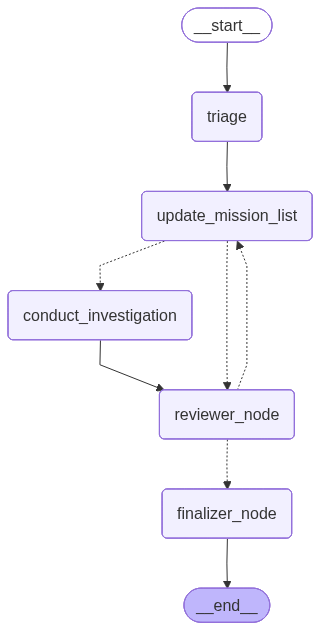

In [50]:
display(Image(static_analysis_graph.get_graph().draw_mermaid_png()))

In [51]:
file_path = "/Users/gorelik/Courses/pdf-hunter/tests/87c740d2b7c22f9ccabbdef412443d166733d4d925da0e8d6e5b310ccfc89e13.pdf"
output_directory="output"
additional_context="None"
session_id="123"

In [52]:
for event_g in static_analysis_graph.stream({"file_path":file_path,"output_directory": output_directory, "additional_context": additional_context, "session_id": session_id}, stream_mode="values"):
    # Review
    print(event_g)

{'session_id': '123', 'file_path': '/Users/gorelik/Courses/pdf-hunter/tests/87c740d2b7c22f9ccabbdef412443d166733d4d925da0e8d6e5b310ccfc89e13.pdf', 'output_directory': 'output', 'additional_context': 'None', 'completed_investigations': [], 'errors': []}
--- Triage Node: Starting Initial Analysis ---
Triage Decision: PDF is Suspicious. Found 4 mission(s).
{'session_id': '123', 'file_path': '/Users/gorelik/Courses/pdf-hunter/tests/87c740d2b7c22f9ccabbdef412443d166733d4d925da0e8d6e5b310ccfc89e13.pdf', 'output_directory': 'output', 'additional_context': 'None', 'structural_summary': {'pdfid': 'PDFiD 0.2.10 /Users/gorelik/Courses/pdf-hunter/tests/87c740d2b7c22f9ccabbdef412443d166733d4d925da0e8d6e5b310ccfc89e13.pdf\n PDF Header: %PDF-1.5\n obj                   97\n endobj                97\n stream                94\n endstream             94\n xref                   0\n trailer                0\n startxref              1\n /Page                  0\n /Encrypt               0\n /ObjStm       

/var/folders/jg/8775l8r94lj_rxbjb0d_th_h0000gn/T/ipykernel_572/2719509289.py:12: PydanticDeprecatedSince20: The `copy` method is deprecated; use `model_copy` instead. See the docstring of `BaseModel.copy` for details about how to handle `include` and `exclude`. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  current_master_graph = state.get('master_evidence_graph', EvidenceGraph()).copy(deep=True)
/var/folders/jg/8775l8r94lj_rxbjb0d_th_h0000gn/T/ipykernel_572/2719509289.py:16: PydanticDeprecatedSince20: The `copy` method is deprecated; use `model_copy` instead. See the docstring of `BaseModel.copy` for details about how to handle `include` and `exclude`. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  mission_map = {m.mission_id: m.copy(deep=True) for m in state['mission_list']}


Graph Merge Summary: Duplicates were identified for obj_2, obj_4, obj_7, and the IOC URL node. For obj_2, all unique properties from both versions were merged, including both 'OpenAction', 'AcroForm', 'Pages', and the 'References' and 'RawContent' fields. For obj_4, the most informative label ('/Launch Action') was kept, and all unique properties were merged, including 'S', 'Win', and 'type'. For obj_7, all unique properties were merged, including 'F', 'P', 'P_hex', and 'P_decoded', and the most descriptive label was kept. For the IOC URL, all references to the same URL were merged into a single node ('ioc_theme_smart_scr') with the most descriptive label. All unique edges were preserved, and redundant edges (identical source, target, and label) were avoided. Node IDs were kept consistent and meaningful, and the graph now represents a deduplicated, comprehensive view of the evidence.
Reviewer: Starting Strategic Review...
Reviewer Strategic Summary: All investigative missions have been

In [53]:
event_g.keys()

dict_keys(['session_id', 'file_path', 'output_directory', 'additional_context', 'structural_summary', 'mission_list', 'mission_reports', 'master_evidence_graph', 'completed_investigations', 'errors', 'triage_classification_decision', 'triage_classification_reasoning', 'final_report'])

In [54]:
event_g["master_evidence_graph"]

EvidenceGraph(nodes=[EvidenceNode(id='obj_1', node_type='PDFObject', label='/ObjStm containing /Launch', properties=[NodeProperty(key='type', value='/ObjStm'), NodeProperty(key='contains', value=['obj_4', 'obj_7']), NodeProperty(key='raw_content_excerpt', value='<< /Type /ObjStm ... /S /Launch /Win 7 0 R ... >>')]), EvidenceNode(id='obj_2', node_type='PDFObject', label='/Catalog (Root)', properties=[NodeProperty(key='Type', value='/Catalog'), NodeProperty(key='OpenAction', value='4 0 R'), NodeProperty(key='AcroForm', value='6 0 R'), NodeProperty(key='Pages', value='5 0 R'), NodeProperty(key='References', value=['4 0 R', '5 0 R', '6 0 R']), NodeProperty(key='RawContent', value='<< /OpenAction 4 0 R /Pages 5 0 R /Type /Catalog /AcroForm 6 0 R /Version /1.5 >>')]), EvidenceNode(id='obj_4', node_type='PDFObject', label='/Launch Action', properties=[NodeProperty(key='S', value='/Launch'), NodeProperty(key='Win', value='7 0 R'), NodeProperty(key='type', value='/Action')]), EvidenceNode(id='o

In [57]:
event_g["final_report"].full_markdown_report

"# Digital Pathology Autopsy Report\n\n## Executive Summary\nThis PDF is weaponized with a malicious /Launch action that, when triggered, executes a Windows command to disable antivirus protection, download a remote executable, establish persistence, and clean up traces. The attack is fully automated and requires only that the user open the PDF and allow the action to run, making it a severe threat to Windows systems. The file should be considered highly dangerous and must not be opened in any environment.\n\n## Step-by-Step Attack Chain\n\n1. **PDF Opened: /OpenAction Triggered**  \n   The root /Catalog object (obj_2) specifies an /OpenAction that is automatically executed when the PDF is opened.\n\n2. **/Launch Action Invoked**  \n   The /OpenAction points to a /Launch action (obj_4), which is designed to execute an external program on Windows systems.\n\n3. **Windows Launch Parameters Provided**  \n   The /Launch action references a file specification (obj_7) with /F (CMD) and a /P 

In [58]:
from IPython.display import Markdown, display

display(Markdown(event_g["final_report"].full_markdown_report))

# Digital Pathology Autopsy Report

## Executive Summary
This PDF is weaponized with a malicious /Launch action that, when triggered, executes a Windows command to disable antivirus protection, download a remote executable, establish persistence, and clean up traces. The attack is fully automated and requires only that the user open the PDF and allow the action to run, making it a severe threat to Windows systems. The file should be considered highly dangerous and must not be opened in any environment.

## Step-by-Step Attack Chain

1. **PDF Opened: /OpenAction Triggered**  
   The root /Catalog object (obj_2) specifies an /OpenAction that is automatically executed when the PDF is opened.

2. **/Launch Action Invoked**  
   The /OpenAction points to a /Launch action (obj_4), which is designed to execute an external program on Windows systems.

3. **Windows Launch Parameters Provided**  
   The /Launch action references a file specification (obj_7) with /F (CMD) and a /P parameter containing a hex-encoded command line.

4. **Malicious Command Decoded and Executed**  
   The /P parameter decodes to a batch and VBScript payload (art_decoded_payload) that:
   - Disables Windows Defender real-time monitoring.
   - Downloads a remote executable (`Theme_Smart.scr`) from a malicious URL.
   - Moves the downloaded file to the Windows Startup folder for persistence.
   - Deletes the batch file and VBScript to clean up traces.

5. **Malware Downloaded and Persisted**  
   The payload downloads the file from `https://badreddine67.000webhostapp.com/Theme_Smart.scr` (ioc_theme_smart_scr) and ensures it will run automatically on system startup.

## Indicators of Compromise (IoCs)

| Type | Value | Source Mission |
|------|-------|---------------|
| URL  | https://badreddine67.000webhostapp.com/Theme_Smart.scr | investigate_OpenAction_87c740d2b7c22f9ccabbdef412443d166733d4d925da0e8d6e5b310ccfc89e13 |

## Detailed Investigation Narrative

### 1. Initial Discovery: /OpenAction and /Launch
The investigation began by examining the /OpenAction entry in the PDF's /Catalog object (obj_2). This entry pointed to a /Launch action (obj_4), a known high-risk feature in PDFs capable of executing external programs. The mission reports unanimously flagged this as a critical threat vector.

### 2. Deep Dive: /Launch Action Parameters
The /Launch action was found to be configured for Windows, referencing a file specification (obj_7) with /F (CMD) and a /P parameter. The /P parameter was a long hex-encoded string, which, upon decoding, revealed a sophisticated command sequence. This sequence was designed to:
- Disable Windows Defender's real-time monitoring (using PowerShell's `Set-MpPreference`).
- Download a remote executable (`Theme_Smart.scr`) from a suspicious domain.
- Move the downloaded file to the Windows Startup folder, ensuring persistence.
- Clean up by deleting the batch file and the VBScript used for execution.

### 3. Payload Analysis
The decoded payload (art_decoded_payload) was a multi-stage dropper, combining batch scripting and VBScript to evade detection and ensure silent execution. The use of both scripting languages, along with the disabling of security features, demonstrates a high level of intent and sophistication.

### 4. Malicious Infrastructure
The investigation identified a single, clear Indicator of Compromise: the URL `https://badreddine67.000webhostapp.com/Theme_Smart.scr`. This URL is used to deliver the final malware payload to the victim's system.

### 5. AcroForm Analysis
A parallel investigation into the /AcroForm object (obj_6) confirmed it was benign, containing no fields, JavaScript, or actions. This ruled out alternative attack vectors within the PDF.

### 6. Conclusion
All evidence converges on a single, highly weaponized attack chain leveraging the PDF's /OpenAction and /Launch features to deliver and persist malware on Windows systems. The attack is fully automated, requires minimal user interaction, and is designed to evade basic security controls. The file is conclusively malicious and should be treated as a severe threat.

---

**Final Verdict:** MALICIOUS

**Do not open this PDF. Quarantine and block the identified IoC immediately.**